# Wineteller : Reminder


- Build a wine recommender based on occasion rather than intrinsic wine characteristics 

- Deduce occasion from wine descriptors that can fit an atmosphere -> Body, Complexity, Finish 

- Use Computational Wine Wheel (mappings) to extract only words that are specific to Body, Complexity and Finish

- Train a Word2Vec model -> clusterize with K-means

# Data Exploration

In [1]:
#python
import pandas as pd
import string
import numpy as np

#compute cell-executing time
from tqdm.notebook import trange, tqdm

#text preprocessing
from operator import itemgetter
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from collections import Counter, OrderedDict

#nlp modeling
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

#clusterization 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from nltk.cluster import KMeansClusterer
import nltk
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Load Data

In [2]:
file_location = '/Users/hyunoochang/code/chyunoo/wineteller/raw_data/winemag-data_first150k.csv'

data = pd.read_csv(file_location, index_col='Unnamed: 0')
print(data.shape)

(150930, 10)


In [3]:
data.head(5)

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [4]:
#Sample for fast test
#data=data[:1000]

## Clean Data

In [5]:
data.isna().sum()

country            5
description        0
designation    45735
points             0
price          13695
province           5
region_1       25060
region_2       89977
variety            0
winery             0
dtype: int64

In [6]:
data.drop(columns = ["region_1", "region_2", "points", "price", "designation", "winery"], inplace=True)

In [7]:
data = data.drop_duplicates()
data.shape

(97833, 4)

# Data Preprocessing

## Tokenize into sentences

In [8]:
%%time
#tokenization : reviews -> sentences

reviews_list = list(data['description'])
reviews_list = [str(r) for r in reviews_list]

sentences_tokenized=[]
for review in tqdm(reviews_list) :
    sentences_tokenized.append(sent_tokenize(review))
sentences_tokenized = [item for sublist in sentences_tokenized for item in sublist]

  0%|          | 0/97833 [00:00<?, ?it/s]

CPU times: user 8.58 s, sys: 337 ms, total: 8.92 s
Wall time: 9.18 s


In [9]:
len(sentences_tokenized)

270453

In [10]:
sentences_tokenized[:1]

['This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak.']

## Remove stopwords and punctuation

In [11]:
%%time
#normalization : remove stopwords and punctuation + tokenize sentences into words

stop_words = set(stopwords.words('english')) 

punctuation_table = str.maketrans({key: None for key in string.punctuation})
sno = SnowballStemmer('english')

def normalize_text(raw_text):
    try:
        word_list = word_tokenize(raw_text)
        normalized_sentence = []
        for w in word_list:
            try:
                w = str(w)
                lower_case_word = str.lower(w)
                stemmed_word = sno.stem(lower_case_word)
                no_punctuation = stemmed_word.translate(punctuation_table)
                if len(no_punctuation) > 1 and no_punctuation not in stop_words:
                    normalized_sentence.append(no_punctuation)
            except:
                continue
        return normalized_sentence
    except:
        return ''

sentence_sample = sentences_tokenized[:10]
normalized_sentences = []
for s in tqdm(sentences_tokenized) :
    normalized_text = normalize_text(s)
    normalized_sentences.append(normalized_text)

  0%|          | 0/270453 [00:00<?, ?it/s]

CPU times: user 1min 51s, sys: 1.64 s, total: 1min 53s
Wall time: 1min 52s


In [12]:
normalized_sentences[:1]

[['tremend',
  '100',
  'variet',
  'wine',
  'hail',
  'oakvill',
  'age',
  'three',
  'year',
  'oak']]

## N-grams

In [13]:
%%time 
#retrieve bi-grams and tri-grams from normalized sentences

phrases = Phrases(normalized_sentences)
phrases = Phrases(phrases[normalized_sentences])

ngrams = Phraser(phrases)

phrased_sentences = []
for sent in tqdm(normalized_sentences):
    phrased_sentence = ngrams[sent]
    phrased_sentences.append(phrased_sentence)

full_list_words = [item for sublist in phrased_sentences for item in sublist]

  0%|          | 0/270453 [00:00<?, ?it/s]

CPU times: user 19.6 s, sys: 194 ms, total: 19.8 s
Wall time: 19.8 s


In [14]:
phrased_sentences[:1]

[['tremend',
  '100_variet',
  'wine',
  'hail',
  'oakvill',
  'age',
  'three_year',
  'oak']]

In [15]:
full_list_words[:5]

['tremend', '100_variet', 'wine', 'hail', 'oakvill']

In [16]:
#most common 5000 words in corpus

word_counts = Counter(full_list_words)
sorted_counts = OrderedDict(word_counts.most_common(5000))
counter_df = pd.DataFrame.from_dict(sorted_counts, orient='index')
top_5000_words = counter_df.head(5000)
counter_df.to_csv('top_5000_descriptors.csv')

In [17]:
top_5000_words.head()

,0
wine,60956
flavor,55898
fruit,40089
finish,29733
acid,25915


## Filter wine descriptors

### Load descriptor mapping

In [18]:
#load wine descriptor_mapping
map_location = '/Users/hyunoochang/code/chyunoo/wineteller/raw_data/descriptor_mapping.csv'

descriptor_mapping = pd.read_csv(map_location).set_index('raw descriptor')
descriptor_mapping.head()

,level_3,level_2,level_1
raw descriptor,,,
abras,abrasive,high_tannin,tannin
acacia,acacia,flowery,flower
acacia_flower,acacia,flowery,flower
aciddriven,acid_driven,high_acid,acid
aggress,aggressive,high_acid,acid


In [19]:
descriptor_mapping.level_1.value_counts()

fruit              235
vegetal             90
woody               77
tannin              72
earth_inorganic     68
acid                63
body                57
spice               46
caramel             44
flower              38
visual              30
earth_organic       27
sweetness           22
sulfides            21
nutty               19
microbial           17
concentration       17
complexity          16
alcohol             16
brettanomyces       15
style               11
salinity             8
finish               6
Name: level_1, dtype: int64

In [20]:
#We keep ALL non-aroma descriptors and exclude aroma descriptors

descriptor_list = ['body', 'complexity', 'finish', 'concentration','alcohol', 'visual', 'sweetness']
filtered_descriptor_mapping = descriptor_mapping[descriptor_mapping['level_1'].isin(descriptor_list)]

In [21]:
filtered_descriptor_mapping.head()

,level_3,level_2,level_1
raw descriptor,,,
airi,airy,light_bodied,body
bake,baked,high_alcohol,alcohol
bland,bland,low_concentration,concentration
blue,blue,color,visual
blue_black,blue_black,color,visual


In [22]:
#number of raw descriptors per features 
filtered_descriptor_mapping["level_1"].value_counts()

body             57
visual           30
sweetness        22
concentration    17
alcohol          16
complexity       16
finish            6
Name: level_1, dtype: int64

In [23]:
print('filtered descriptors :', round((filtered_descriptor_mapping["level_1"].value_counts().sum()/descriptor_mapping.level_1.value_counts().sum())*100),'% ,',filtered_descriptor_mapping["level_1"].value_counts().sum(), 'out of', descriptor_mapping.level_1.value_counts().sum())

filtered descriptors : 16 % , 164 out of 1015


In [24]:
#list of all raw descriptors (body, finish, complexity)
print(list(filtered_descriptor_mapping.index),)

['airi', 'bake', 'bland', 'blue', 'blue_black', 'big_bold', 'bone_dri', 'bonedri', 'brick', 'brilliant', 'brown', 'bullish', 'blocki', 'chunki', 'solid_chunki', 'clampi', 'close', 'cloy', 'complex', 'complic', 'concentr', 'deepli_concentr', 'dainti', 'dark', 'dark_color', 'deep_color', 'dens', 'dens_pack', 'densiti', 'deep', 'depth', 'dilut', 'dri', 'drier', 'dryness', 'dull', 'eas', 'easi_sip', 'eleg', 'expans', 'extract', 'fat', 'feminin', 'finess', 'ampl_weight', 'bold', 'full_bodi', 'fullbodi', 'soupi', 'weighti', 'gold', 'gold_color', 'golden', 'golden_color', 'green', 'headi', 'hearti', 'heavi', 'heavier', 'heavyweight', 'bigger', 'high_alcohol', 'highoctan', 'hollow', 'alcohol_heat', 'heat', 'heat_evid', 'hot', 'lavish', 'rather_lean', 'length', 'lengthi', 'long_mouthwat', 'longlast', 'lightest', 'light', 'light_bodi', 'lightbodi', 'lighter', 'lighter_style', 'lightfoot', 'lightweight', 'thin', 'lighter_color', 'linear', 'light_feet', 'low_alcohol', 'lowalcohol', 'straightforwar

### Apply mapping to sentences

In [25]:
%%time
#apply mapping on each word of each sentence

def return_mapped_descriptor(word):
    if word in list(filtered_descriptor_mapping.index):
        normalized_word = filtered_descriptor_mapping['level_3'][word]
        return normalized_word
    else:
        return ""

normalized_sentences = []
for sent in tqdm(phrased_sentences):
    normalized_sentence = []
    for word in sent:
        normalized_word = return_mapped_descriptor(word)
        if normalized_word != "" :
            normalized_sentence.append(str(normalized_word))
        else :
            pass
    normalized_sentences.append(normalized_sentence)

  0%|          | 0/270453 [00:00<?, ?it/s]

CPU times: user 47.7 s, sys: 582 ms, total: 48.3 s
Wall time: 48.1 s


In [26]:
normalized_sentences[:10]

[[],
 ['elegant'],
 [],
 [],
 [],
 ['rich'],
 ['heady'],
 [],
 ['complex', 'white'],
 ['dark', 'gold', 'succulent', 'sugar']]

In [27]:
len(normalized_sentences)

270453

# Model

## Train model 

In [28]:
%%time
#fit Word2Vec model into corpus 
model = Word2Vec(normalized_sentences, vector_size=300, min_count=1, epochs=15)
print(model)

model.save('model.bin')

Word2Vec<vocab=102, vector_size=300, alpha=0.025>
CPU times: user 6.33 s, sys: 72.1 ms, total: 6.41 s
Wall time: 5.56 s


In [29]:
#list of vocab learned by model
print(model.wv.index_to_key,)

['dry', 'rich', 'sweet', 'light_bodied', 'complex', 'dark', 'elegant', 'full_bodied', 'concentrated', 'dense', 'powerful', 'white', 'green', 'depth', 'medium_bodied', 'lush', 'closed', 'heavy', 'warm', 'weight', 'thick', 'hot', 'baked', 'opulent', 'sugar', 'extracted', 'chunky', 'plump', 'yellow', 'bone_dry', 'modest', 'high_alcohol', 'refined', 'syrupy', 'length', 'low_complexity', 'restrained', 'succulent', 'off-dry', 'robust', 'mellow', 'residual_sugar', 'sticky', 'linear', 'gold', 'shine', 'finessed', 'fat', 'hearty', 'pungent', 'lengthy', 'sturdy', 'purple', 'brilliant', 'heady', 'watery', 'cloying', 'dull', 'one_dimensional', 'medium_sweet', 'blue', 'low_alcohol', 'voluptuous', 'luminous', 'diluted', 'bold', 'oxidized', 'feminine', 'luxurious', 'pale', 'bland', 'viscous', 'pink', 'complicated', 'lavish', 'medium_length_finish', 'murky', 'ruby_color', 'unoaked', 'mass', 'simple', 'hollow', 'pink_color', 'expansive', 'quaffer', 'punchy', 'super_rich', 'pale_color', 'brown', 'easy',

## Explore Word Embeddings

In [31]:
#Find most similar from vector
#wv = preprocessed_data.loc[4,"review_vector"]
#wv = np.squeeze(wv, axis=0)
#print(wv.shape)
#model.wv.most_similar(positive=[wv,], topn=10)

In [32]:
#Find most similar word 
model.wv.most_similar(positive='light_bodied', topn=10)

[('pale', 0.9841611385345459),
 ('luminous', 0.9732427597045898),
 ('modest', 0.9718283414840698),
 ('pink', 0.9566826820373535),
 ('low_complexity', 0.9514191746711731),
 ('medium_bodied', 0.9506207704544067),
 ('white', 0.9395122528076172),
 ('green', 0.913936972618103),
 ('simple', 0.9084933996200562),
 ('dainty', 0.9065003991127014)]

In [33]:
#Retrieve vector from word 
#model.wv["light_bodied"]

In [34]:
#Compute distance between two words/vectors
#cosine_similarity([model.wv["light_bodied"]], [wv])

NameError: name 'wv' is not defined

## Return mapped descriptors from reviews

In [35]:
%%time
wine_reviews = list(data['description'])

def return_descriptor_from_mapping(word):
    if word in list(filtered_descriptor_mapping.index):
        descriptor_to_return = filtered_descriptor_mapping['level_3'][word]
        return descriptor_to_return

descriptorized_reviews = []
for review in tqdm(wine_reviews):
    normalized_review = normalize_text(review)
    phrased_review = ngrams[normalized_review]
    descriptors_only = [return_descriptor_from_mapping(word) for word in phrased_review]
    no_nones = [str(d) for d in descriptors_only if d is not None]
    descriptorized_review = ' '.join(no_nones)
    descriptorized_reviews.append(descriptorized_review)

  0%|          | 0/97833 [00:00<?, ?it/s]

CPU times: user 2min 57s, sys: 2.88 s, total: 3min
Wall time: 3min 1s


In [36]:
descriptorized_reviews[:5]

['elegant',
 'rich heady',
 'complex white dark gold succulent sugar',
 'dense',
 'dense rich concentrated']

In [37]:
len(descriptorized_reviews)

97833

## Calculate Review Vectors with TFIDF

In [38]:
%%time

#apply Tfidf weights and compute wine review vectors from word vectors

vectorizer = TfidfVectorizer()
X = vectorizer.fit(descriptorized_reviews)

dict_of_tfidf_weightings = dict(zip(X.get_feature_names(), X.idf_))

CPU times: user 523 ms, sys: 15.6 ms, total: 538 ms
Wall time: 560 ms


/Users/hyunoochang/.pyenv/versions/3.8.12/envs/wineteller/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [39]:
%%time
wine_review_vectors = []
for d in tqdm(descriptorized_reviews):
    descriptor_count = 0
    weighted_review_terms = []
    terms = d.split(' ')
    for term in terms:
        if term in dict_of_tfidf_weightings.keys():
            tfidf_weighting = dict_of_tfidf_weightings[term]
            word_vector = model.wv.get_vector(term).reshape(1, 300)
            weighted_word_vector = tfidf_weighting * word_vector
            weighted_review_terms.append(weighted_word_vector)
            descriptor_count += 1
        else:
            continue
    try:
        review_vector = sum(weighted_review_terms)/len(weighted_review_terms)
    except:
        review_vector = []
    vector_and_count = [terms, review_vector, descriptor_count]
    wine_review_vectors.append(vector_and_count)

  0%|          | 0/97833 [00:00<?, ?it/s]

CPU times: user 2.77 s, sys: 151 ms, total: 2.92 s
Wall time: 2.95 s


## Merge in final dataset 

In [40]:
#concatenante in new dataset
data['normalized_descriptors'] = list(map(itemgetter(0), wine_review_vectors))
data['review_vector'] = list(map(itemgetter(1), wine_review_vectors))
data['descriptor_count'] = list(map(itemgetter(2), wine_review_vectors))

data.reset_index(inplace=True)

In [41]:
data.head()

,index,country,description,province,variety,normalized_descriptors,review_vector,descriptor_count
0,0,US,This tremendous 100% varietal wine hails from ...,California,Cabernet Sauvignon,[elegant],"[[0.14686473, -0.27617994, 0.058567908, 0.1964...",1
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Northern Spain,Tinta de Toro,"[rich, heady]","[[-0.36269706, 0.48579144, 0.21448109, 0.16235...",2
2,2,US,Mac Watson honors the memory of a wine once ma...,California,Sauvignon Blanc,"[complex, white, dark, gold, succulent, sugar]","[[-0.17364222, 0.18122871, 0.06022341, 0.12081...",6
3,3,US,"This spent 20 months in 30% new French oak, an...",Oregon,Pinot Noir,[dense],"[[-0.26432416, 0.49408934, 0.37247324, 0.58973...",1
4,4,France,"This is the top wine from La Bégude, named aft...",Provence,Provence red blend,"[dense, rich, concentrated]","[[-0.25526938, 0.32110444, 0.34150782, 0.19217...",3


In [42]:
data.loc[1,"description"]

'Ripe aromas of fig, blackberry and cassis are softened and sweetened by a slathering of oaky chocolate and vanilla. This is full, layered, intense and cushioned on the palate, with rich flavors of chocolaty black fruits and baking spices. A toasty, everlasting finish is heady but ideally balanced. Drink through 2023.'

In [43]:
#rows with no BCF descriptor 
data = data.drop(columns= "index")
preprocessed_data = data[data["descriptor_count"]>0]
print(preprocessed_data.shape)

(79772, 7)


## Export in csv

In [44]:
#from pathlib import Path  
#filepath = Path('/Users/hyunoochang/code/chyunoo/wineteller/notebooks/preprocessed_data.csv')  
#preprocessed_data.to_csv(filepath)

# Clusterization 

## Prepare dataset 

In [45]:
test = preprocessed_data.copy()

#Convert word index (non hashable) to tuples
test['normalized_descriptors'] = test['normalized_descriptors'].apply(tuple)

#Drop duplicates
test = test.drop_duplicates(subset="normalized_descriptors")

#Create X_train
X_train = test["review_vector"]
X_train = np.array(list(X_train), dtype=np.float)
X_train = np.squeeze(X_train, axis = 1)
X_train.shape

/var/folders/qt/dqfmgcdd30d3k8fh1t4zqmlw0000gn/T/ipykernel_2090/3692848974.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train = np.array(list(X_train), dtype=np.float)


(20871, 300)

## TSNE 

In [46]:
tsne = TSNE(n_components=2, random_state=0)
Y = tsne.fit_transform(X_train)

/Users/hyunoochang/.pyenv/versions/3.8.12/envs/wineteller/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hyunoochang/.pyenv/versions/3.8.12/envs/wineteller/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


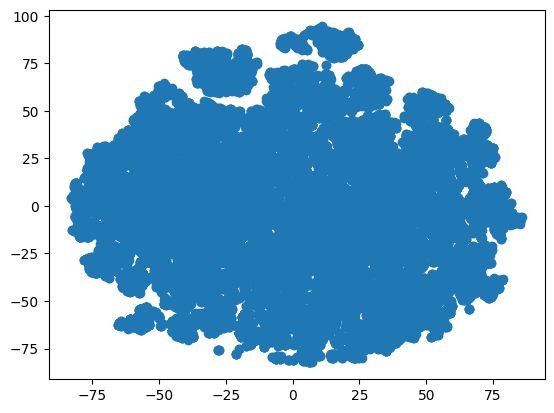

In [47]:
plt.scatter(Y[:, 0], Y[:, 1])

In [48]:
#Code for plotting words (unreadable)
#plt.scatter(Y[:, 0], Y[:, 1])

#for label, x, y in zip(wines, Y[:, 0], Y[:, 1]):
    #plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
#plt.show()

## PCA 

### With Two dimensions

In [49]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X_train)

In [50]:
pca_df = pd.DataFrame(pca_results, index=list(test.normalized_descriptors), columns=["pc1", "pc2"])
pca_df.head()

,pc1,pc2
"(elegant,)",0.739527,-4.510628
"(rich, heady)",-0.840676,0.284687
"(complex, white, dark, gold, succulent, sugar)",1.252567,0.717953
"(dense,)",-4.349350,-0.256163
"(dense, rich, concentrated)",-2.638772,-0.806404


<AxesSubplot:xlabel='pc1', ylabel='pc2'>

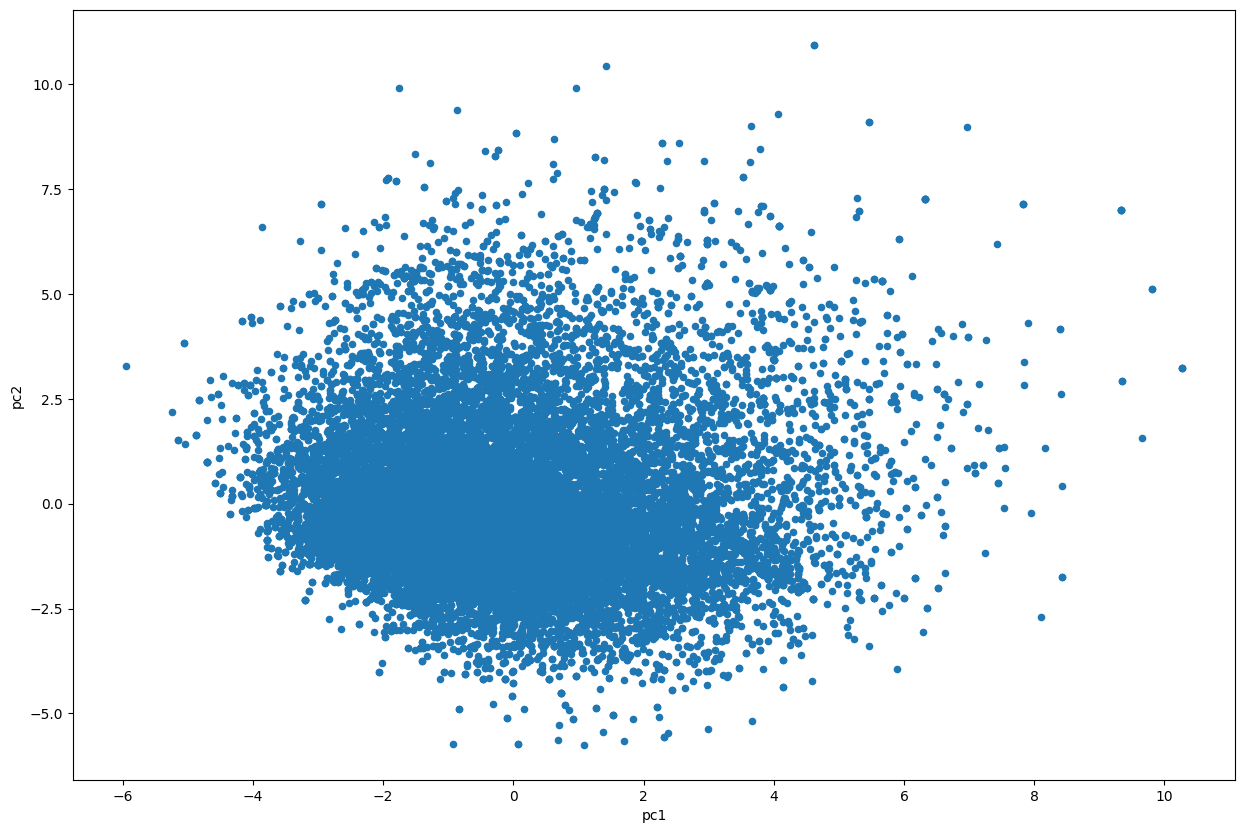

In [51]:
pca_df.plot(x='pc1',y='pc2',kind="scatter",figsize=(15, 10))

In [52]:
wine_words = [str(word).strip("(),' '") for word in pca_df.index]
print(len(wine_words,))

20871


In [53]:
pca_df.index = wine_words
pca_df.head()

,pc1,pc2
elegant,0.739527,-4.510628
"rich', 'heady",-0.840676,0.284687
"complex', 'white', 'dark', 'gold', 'succulent', 'sugar",1.252567,0.717953
dense,-4.349350,-0.256163
"dense', 'rich', 'concentrated",-2.638772,-0.806404


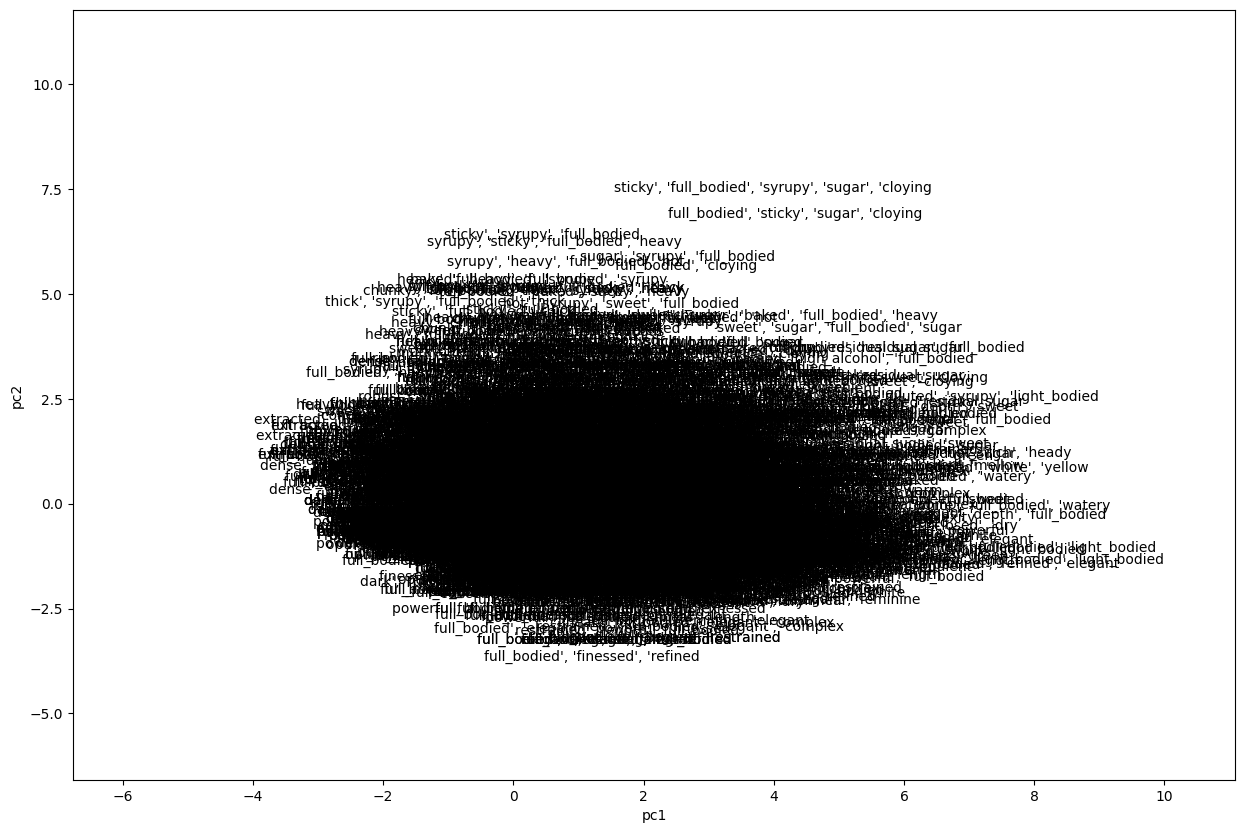

In [54]:
ax = pca_df.plot(x='pc1',y='pc2',kind="scatter",figsize=(15, 10),alpha=0)
for word in pca_df.index : 
    for txt in ['full_bodied']:
        if txt in word : 
            x = pca_df.pc1.loc[word]
            y = pca_df.pc2.loc[word]
            ax.annotate(word, (x,y))
plt.show()

In [55]:
for v in pca.explained_variance_ratio_:
    print('Explained variation per principal component: {}%'.format(round(v*100,2)))

Explained variation per principal component: 37.68%
Explained variation per principal component: 37.11%


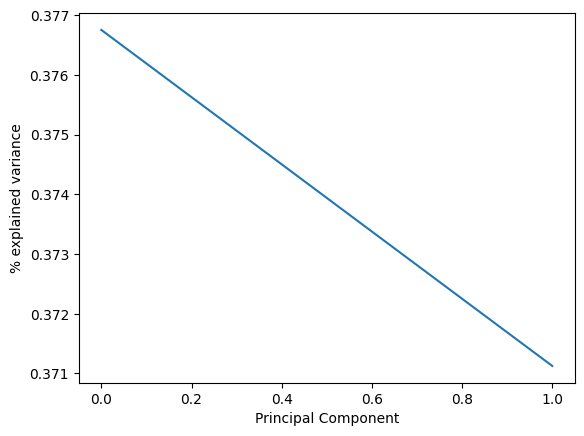

In [56]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component'); plt.ylabel('% explained variance');

### With Max Dimensions

In [110]:
pca_max = PCA()
pca_max_results = pca_max.fit_transform(X_train)
pca_max_df = pd.DataFrame(pca_max_results, index=list(test.normalized_descriptors), columns= [f'PC{i}' for i in range(1, 301)])

In [111]:
pca_max_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC291,PC292,PC293,PC294,PC295,PC296,PC297,PC298,PC299,PC300
"(elegant,)",0.739527,-4.510628,0.231567,-0.056083,1.278509,-0.843294,-0.598544,-0.272719,-0.262196,1.227528,...,-1.071299e-09,-9.767911e-10,-7.459829e-10,-3.596086e-09,7.705840e-10,1.717077e-09,1.373777e-09,-7.768910e-10,4.563713e-10,-6.327223e-10
"(rich, heady)",-0.840676,0.284687,-0.039519,-0.205119,1.800747,-0.166121,-0.272873,0.020844,0.825738,0.078243,...,7.632869e-10,-3.074468e-10,-5.335412e-09,1.631336e-09,-2.377134e-09,4.493168e-09,-4.373228e-10,-2.389853e-09,-1.669880e-09,-2.052703e-09
"(complex, white, dark, gold, succulent, sugar)",1.252567,0.717953,0.582398,-0.704680,-0.218455,-0.337872,0.765386,0.171710,0.366327,-0.201213,...,-3.121980e-09,-3.866029e-09,-7.153894e-09,6.200425e-09,2.267980e-09,8.571263e-09,-2.037991e-09,-1.394259e-08,1.673207e-08,-1.433230e-09
"(dense,)",-4.349350,-0.256163,0.537893,-0.235921,-0.360074,-0.118187,-1.448832,-1.239201,0.554749,-0.489309,...,-1.969869e-09,1.939576e-09,4.249328e-11,-1.128657e-09,-1.435105e-09,1.806179e-09,-5.006543e-10,2.049818e-09,2.474475e-09,2.292502e-09
"(dense, rich, concentrated)",-2.638772,-0.806404,-0.287533,-0.669317,0.358077,-0.285375,0.167852,0.076065,-0.053723,0.235754,...,5.018456e-09,-4.509435e-09,1.997697e-09,3.239996e-09,1.237969e-08,7.743283e-09,-1.458139e-08,2.159666e-09,-1.108483e-08,4.807599e-09


In [118]:
pca_max.explained_variance_ratio_[:11]

array([0.3767536 , 0.37112576, 0.08245029, 0.04324706, 0.04053477,
       0.02108175, 0.01803245, 0.01558265, 0.01209978, 0.00688161,
       0.00359031])

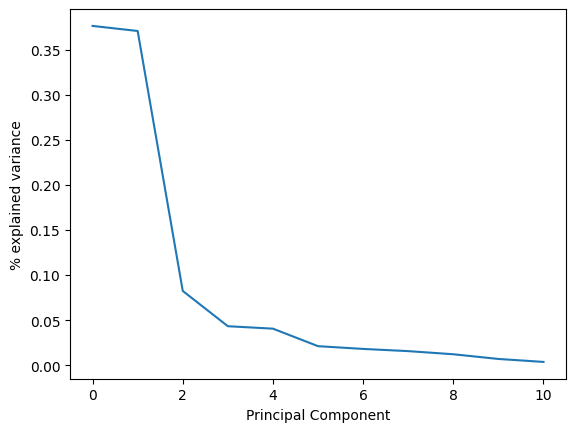

In [120]:
plt.plot(pca_max.explained_variance_ratio_[:11])
plt.xlabel('Principal Component'); plt.ylabel('% explained variance');

## K-Means 

In [59]:
X_proj = pd.DataFrame(pca_results, columns=["pc1", "pc2"])

In [125]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=5) 
km.fit(X_proj)

KMeans(n_clusters=5)

In [122]:
km.cluster_centers_.shape

(10, 2)

In [123]:
print(km.labels_,)

[0 1 5 ... 8 3 3]


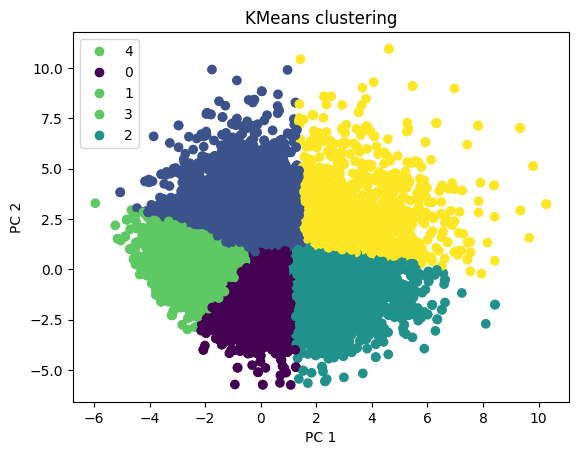

In [126]:
plt.title('KMeans clustering'); plt.xlabel('PC 1'); plt.ylabel('PC 2')
ax = plt.gca()
sc = ax.scatter(X_proj.iloc[:,0], X_proj.iloc[:,1], c=km.labels_)


colors = km.labels_
labels = np.unique(km.labels_)
clset = set(zip(colors, labels))
handles = [plt.plot([],color=sc.get_cmap()(sc.norm(c)),ls="", marker="o")[0] for c,l in clset ]
labels = [l for c,l in clset]
plt.legend(handles, labels)
plt.show()

Text(0.5, 0, 'k cluster number')

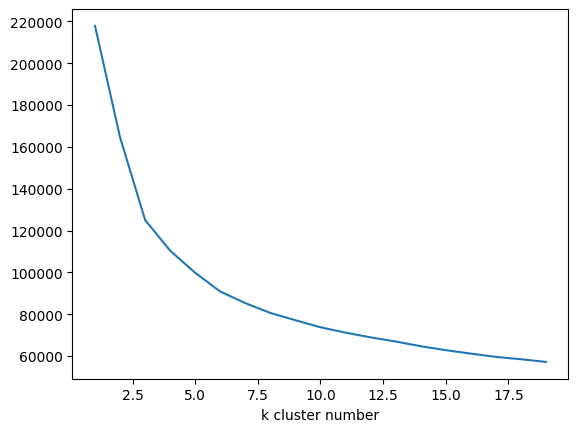

In [67]:
%%time
inertias = []
ks = range(1,20)

for k in ks:
    km_test = KMeans(n_clusters=k).fit(X_train)
    inertias.append(km_test.inertia_)

plt.plot(ks, inertias)
plt.xlabel('k cluster number')

## Word clouds for each cluster

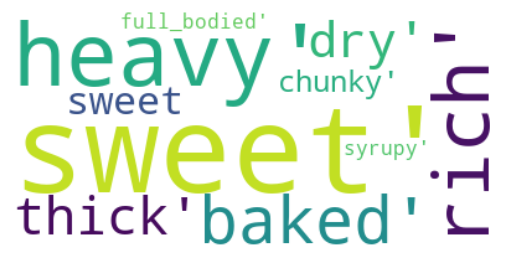

In [127]:
text = str(list(pca_df[km.labels_==1].index))

# Create and generate a word cloud image:
wordcloud = WordCloud(background_color="white", max_words=10).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

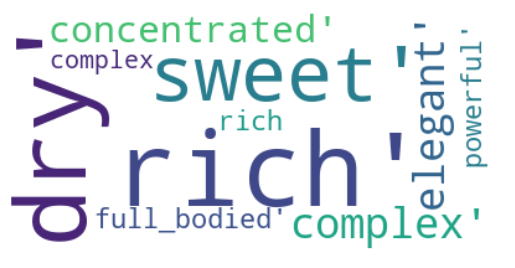

In [128]:
text = str(list(pca_df[km.labels_==0].index))

# Create and generate a word cloud image:
wordcloud = WordCloud(background_color="white", max_words=10).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

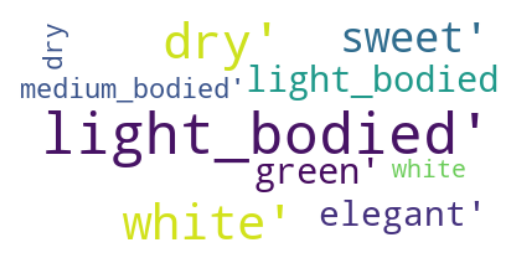

In [129]:
text = str(list(pca_df[km.labels_==2].index))

# Create and generate a word cloud image:
wordcloud = WordCloud(background_color="white", max_words=10).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

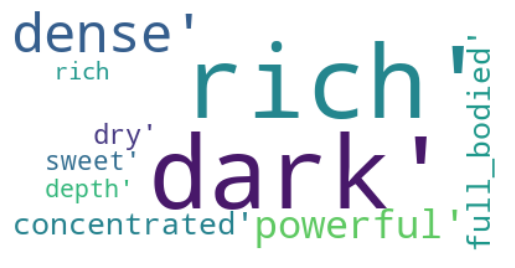

In [130]:
text = str(list(pca_df[km.labels_==3].index))

# Create and generate a word cloud image:
wordcloud = WordCloud(background_color="white", max_words=10).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

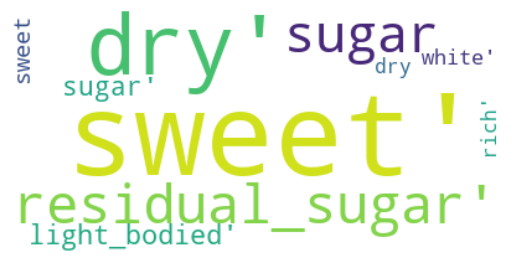

In [131]:
text = str(list(pca_df[km.labels_==4].index))

# Create and generate a word cloud image:
wordcloud = WordCloud(background_color="white", max_words=10).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()